In [33]:
folder_data = 'cropped_imgs_fetal_regions.npy'

## Loading the fetal-parts data

In [34]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import random
import cv2

In [4]:
x_full = np.load(folder_data)
print(x_full.shape)

(180, 224, 224, 3)


In [5]:
with open("manual_annot_CRL_Sagittal.txt", "r") as file:
    # Read the contents of the file
    file_contents = file.read()
lines = file_contents.split('\n')
index = [int(i.split(' ')[0]) for i in lines]
labels = [' '.join(i.split(' ')[1:]) for i in lines]
manual_labels_df = pd.DataFrame()
manual_labels_df['Image ID'] = index
manual_labels_df['label'] = labels

manual_labels_df['label'] = manual_labels_df['label'].apply(lambda x: x.strip())

manual_labels_df = manual_labels_df[manual_labels_df['label'] != 'remove']

num_labels = {'head': 0, 'neck': 1, 'body': 2}

manual_labels_df['encoded_label'] = manual_labels_df['label'].map(num_labels)

y_full = np.array(manual_labels_df['encoded_label'])

In [6]:
print(y_full.shape)

(180,)


In [7]:
min_angle = -30
max_angle = 30

def rotate_image(image, angle):
    # Get image center coordinates
    center = (image.shape[1] / 2, image.shape[0] / 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return rotated_image
rotated_images = []
for img in x_full:
    angle = random.uniform(min_angle, max_angle)
    rotated_img = rotate_image(img, angle)
    rotated_images.append(rotated_img)

rotated_images = np.array(rotated_images)

x = np.concatenate((x_full, rotated_images), axis=0)

y =  np.concatenate((y_full, y_full), axis=0)


In [8]:
print(x.shape)
print(y.shape)

(360, 224, 224, 3)
(360,)


In [9]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

In [10]:
# x_train = x_train.astype("float32") / 255
# x_test = x_test.astype("float32") / 255

## Visualize image dataset

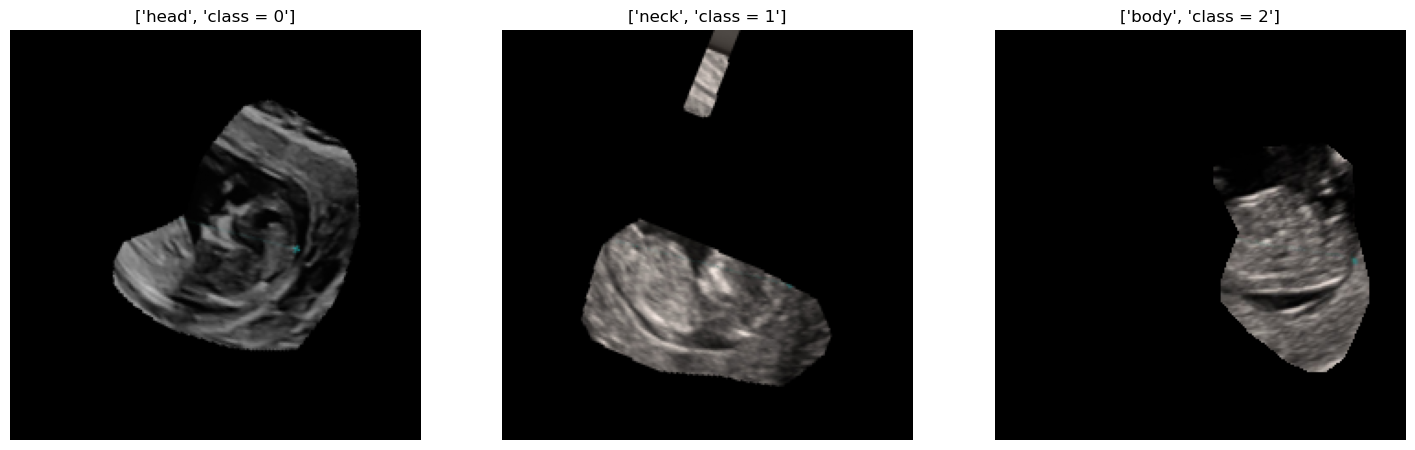

In [11]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pylab as plt

label_names = ['head', 'neck', 'body']

fig = plt.figure(figsize=(18, 8))

for kclass in range(0,3):
    ind = np.argwhere(y_train==kclass)
    ax = fig.add_subplot(1, 3, kclass+1)
    ax.imshow(x_train[ind[0][0]].squeeze())
    ax.set_title([label_names[kclass], 'class = {}'.format(kclass)])
    ax.axis('off')

In [12]:
# Gray-scale versions
x_train_uint8 = (x_train * 255).astype(np.uint8)
x_train_gray = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2]), dtype=np.uint8)
for i in range(len(x_train)):
    x_train_gray[i] = cv2.cvtColor(x_train_uint8[i], cv2.COLOR_RGB2GRAY)

In [13]:
x_test_uint8 = (x_test * 255).astype(np.uint8)

# Convert color images to grayscale
x_test_gray = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2]), dtype=np.uint8)
for i in range(len(x_test)):
    x_test_gray[i] = cv2.cvtColor(x_test_uint8[i], cv2.COLOR_RGB2GRAY)

In [14]:
x_train_gray = np.expand_dims(x_train_gray, -1)
x_test_gray = np.expand_dims(x_test_gray, -1)
print(x_train_gray.shape)
print(x_test_gray.shape)

(288, 224, 224, 1)
(72, 224, 224, 1)


In [15]:
x_uint8 = (x * 255).astype(np.uint8)
x_gray = np.zeros((x.shape[0], x.shape[1], x.shape[2]), dtype=np.uint8)
for i in range(len(x)):
    x_gray[i] = cv2.cvtColor(x_uint8[i], cv2.COLOR_RGB2GRAY)

## Low-dimension projections of the MNIST test data subset

## 2D PCA projection

<Axes: >

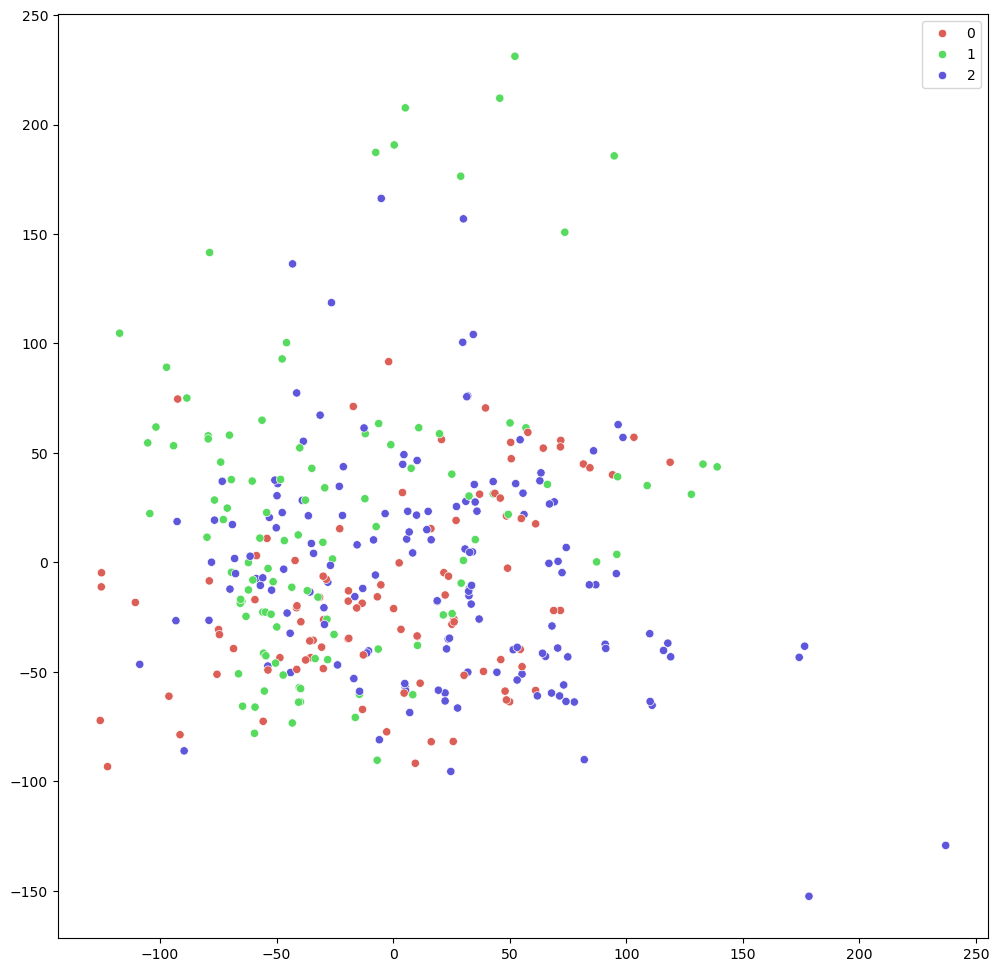

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Reshape datasets as NOBSERVATIONS x NPIXELS (Flatten):
full = x_gray.reshape(x_gray.shape[0],x_gray.shape[1]*x_gray.shape[2])
full = StandardScaler().fit_transform(full)

# PROJECT TO A 2D PCA SPACE:
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(full)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = pca_proj[:,0], y = pca_proj[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full')

In [30]:
pca.explained_variance_ratio_.cumsum()

array([0.0811453 , 0.14898852])

## T-SNE projection

Visualizing high-dimensional data by projecting it into a low-dimensional space

https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf



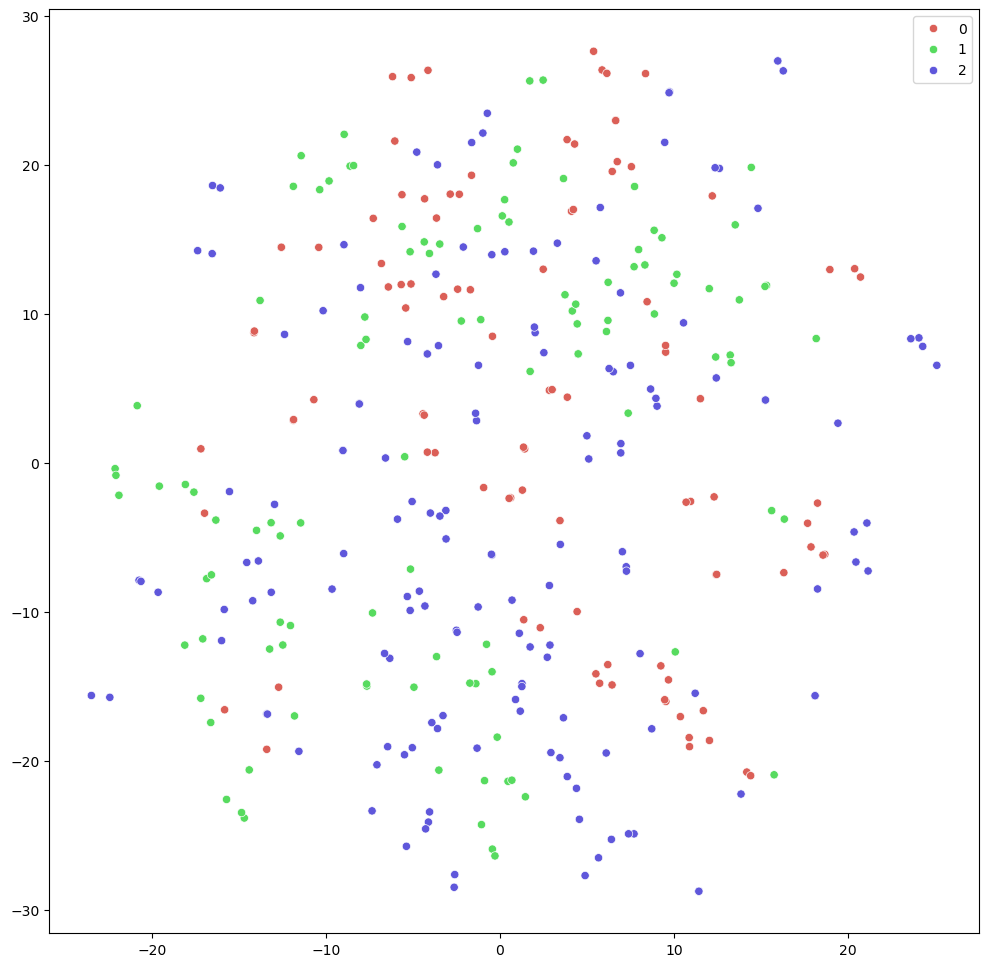

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(full)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

## PCA + t-SNE

Let's first project into a PCA space explaining 95% of the variability and then visualize the PCA projection using a 2D t-SNE manifold

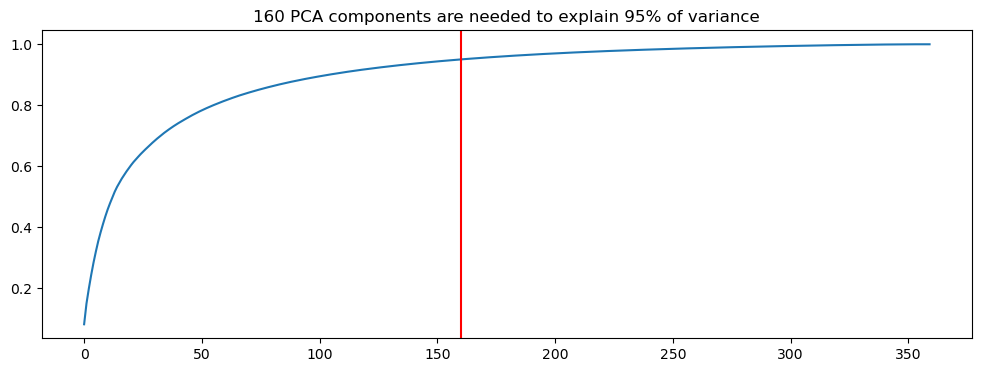

In [32]:
pca_full = PCA(n_components=360)
pca_full.fit(full)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(12,4))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

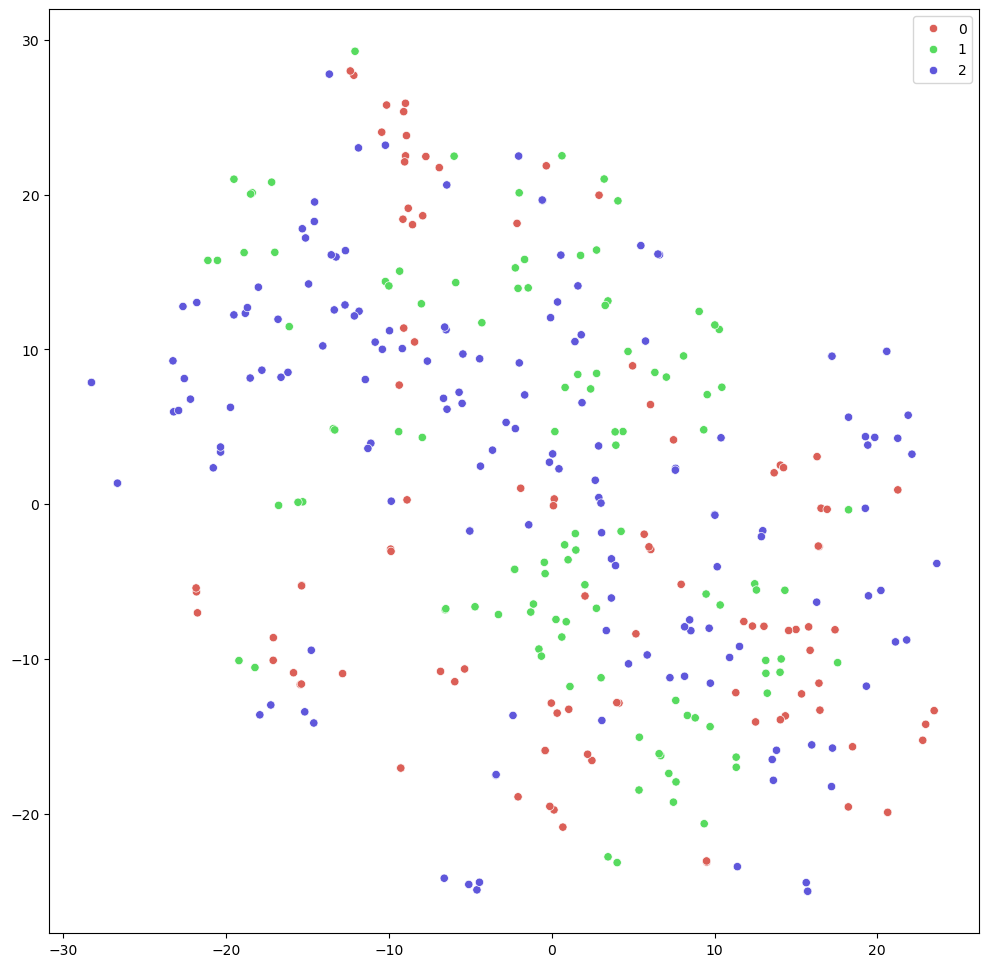

In [33]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(full)

tsne = TSNE(n_components = 2, random_state=0)
tsne_pca = tsne.fit_transform(pca95_proj)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

PCA as feature extraction works pretty well (eigenfaces)

## Clustering - unsupervised approach
In this section we apply an unsupervised clustering approach to identfy each cluster in the feature space. In particular, we apply a Gaussian Mixture Model with model selection using the Bayesian Information Criterion parsimony index.


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: 

[5644.651121531543]
[5644.651121531543, 5634.761835437184]
[5644.651121531543, 5634.761835437184, 5647.619794179233]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835]


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: 

[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835, 5716.351796445057]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835, 5716.351796445057, 5727.466192890254]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835, 5716.351796445057, 5727.466192890254, 5767.4309097055475]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835, 5716.351796445057, 5727.466192890254, 5767.4309097055475, 5790.3270106434475]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835, 5716.351796445057, 5727.466192890254, 5767.4309097055475, 5790.3270106434475, 5806.320482868977]
[5644.651121531543, 5634.761835437184, 5647.619794179233, 5672.422050358841, 5700.49855754167, 5677.2056646056835, 5716.351796445057, 5

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


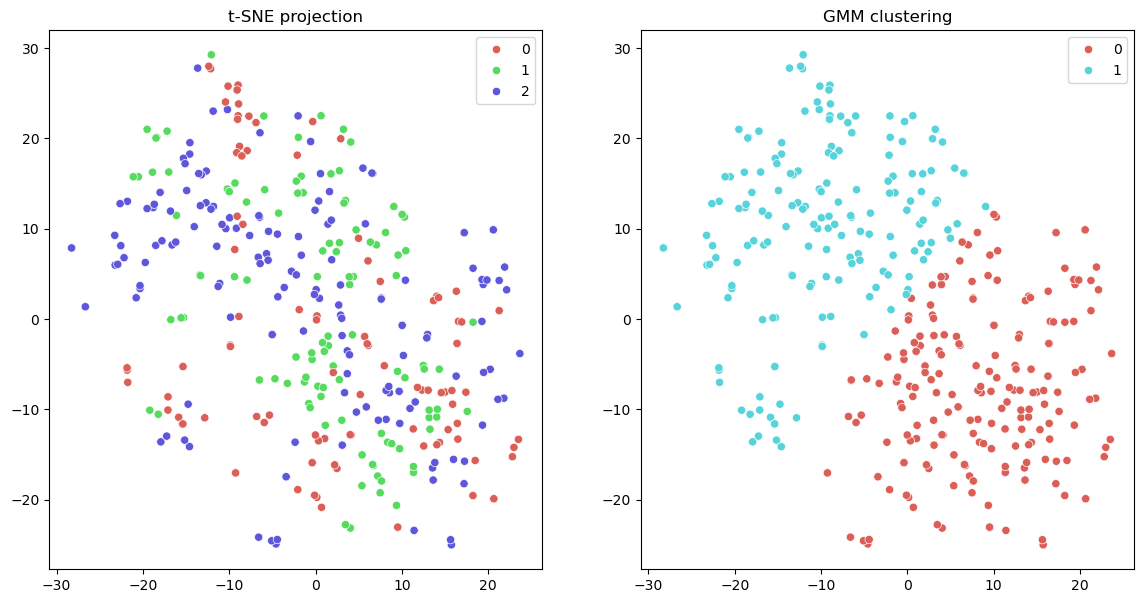

In [34]:
from sklearn import mixture

X = tsne_pca[:,0:2]

NMAX = 12
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(X)
    bic.append(gmm.bic(X))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(X)
y_pred_gmm = gmm.fit_predict(X)

plt.figure(figsize=(14,7))

ax0 = plt.subplot(1,2,1)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');
plt.title("t-SNE projection")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_pred_gmm, palette = sns.hls_palette(idx_winner+1));
plt.title("GMM clustering")
plt.show()

In [35]:
# Getting the adjusted rand score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
print("Adjusted rand-score: ", adjusted_rand_score(y_pred_gmm, y))
print("Accuracy: ", accuracy_score(y_pred_gmm, y))
print("NMI: ", normalized_mutual_info_score(y_pred_gmm, y))

Adjusted rand-score:  0.013879897526601868
Accuracy:  0.29444444444444445
NMI:  0.016025979776051785


Some digits can be easily identified as an isolated cluster, others are identified as two subgroups. We also observe that two different digits are grouped together as a single cluster.

## UMAP Projection


UMAP is a flexible non-linear dimension reduction algorithm that learns the manifold structure of your data and find a low dimensional embedding that preserves its topological structure.

https://arxiv.org/abs/1802.03426

https://umap-learn.readthedocs.io/en/latest/

First, install UMAP library in google colab platform

In [19]:
import umap
import pickle

mapper = umap.UMAP().fit(full) # create the UMAP mapper
embedding = mapper.transform(full) # project data

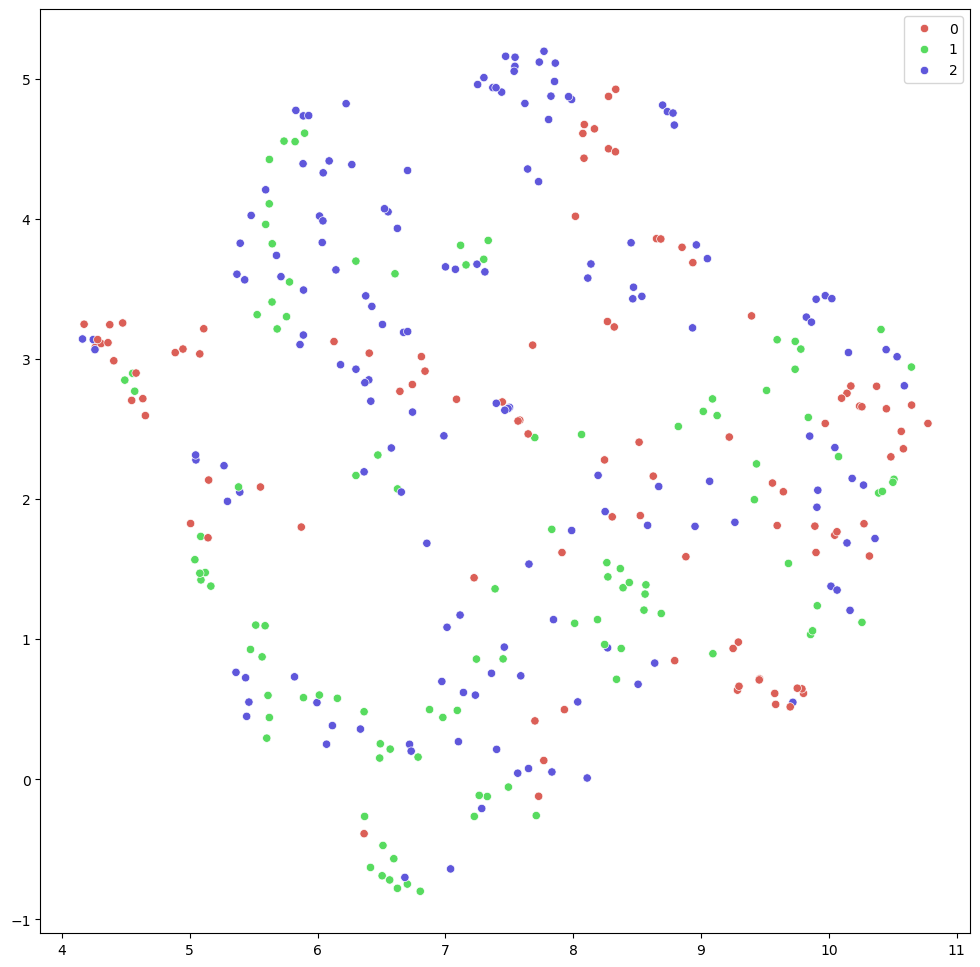

In [20]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

Check if the database is balanced:

In [21]:
for i in range(3):
  print('Class {} has {} samples'.format(i,y[y==i].shape))

Class 0 has (98,) samples
Class 1 has (108,) samples
Class 2 has (154,) samples


# Part 2: The Traditional Machine Learning approach



## Fit a KNN classifier using raw data

              precision    recall  f1-score   support

        head       0.84      1.00      0.92        98
        neck       0.88      0.94      0.91       108
        body       1.00      0.84      0.91       154

    accuracy                           0.91       360
   macro avg       0.91      0.92      0.91       360
weighted avg       0.92      0.91      0.91       360



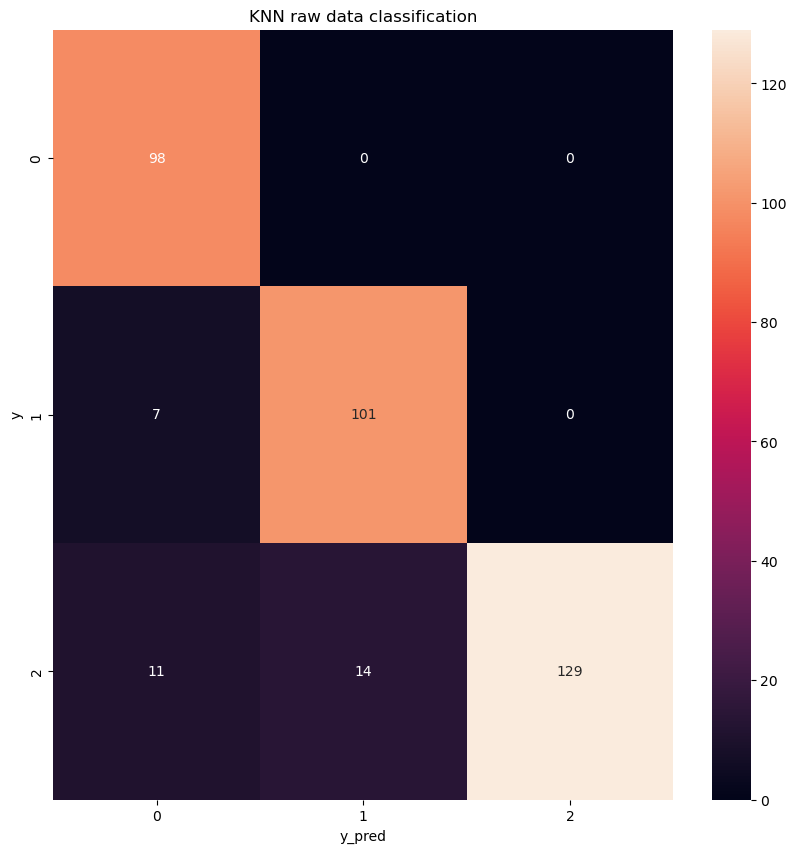

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

knn_raw = KNeighborsClassifier(n_neighbors=2) # load the model
knn_raw.fit(full, y) # fit the model using training data
y_pred_raw = knn_raw.predict(full) # model prediction of test data



cm_raw = confusion_matrix(y, y_pred_raw)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_raw,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title('KNN raw data classification')

label_names = ['head', 'neck', 'body']
print(classification_report(y, y_pred_raw, target_names=label_names))

Number of misclassified images for class 'head': 18


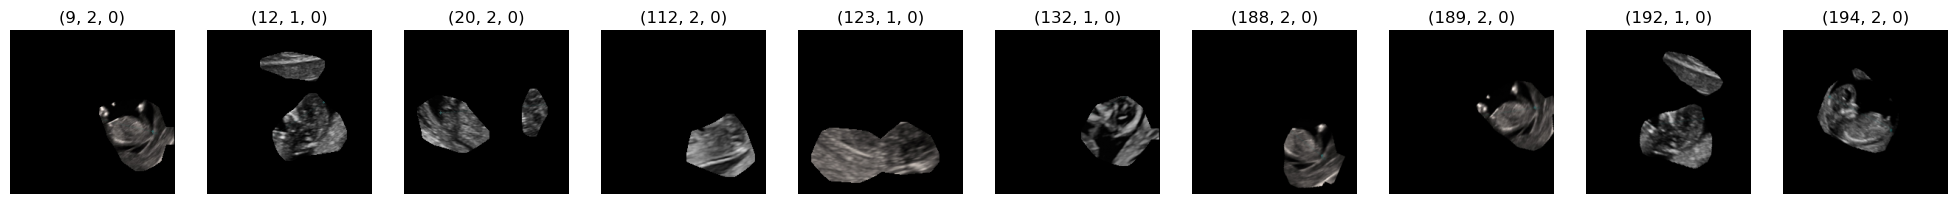

Number of misclassified images for class 'neck': 14


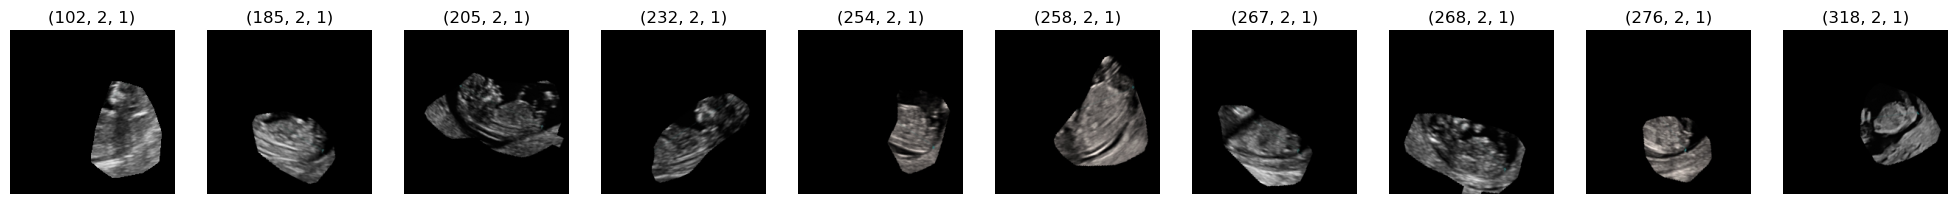

Number of misclassified images for class 'body': 0


In [40]:
# Confused predictions
def plot_misclassified_images(true_labels, predicted_labels, images, class_name):
    ind = {'head':0, 'neck':1, 'body':2}
    class_ind = ind[class_name]
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred and pred == class_ind]
    num_misclassified = len(misclassified_indices)
    
    print(f"Number of misclassified images for class '{class_name}': {num_misclassified}")
    
    if num_misclassified == 0:
        return
    
    plt.figure(figsize=(25, 3))
    for i, index in enumerate(misclassified_indices[:10]):  # plot up to 10 misclassified images
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[index])  # Assuming images is a list of numpy arrays
        plt.title(f'({index}, {true_labels[index]}, {predicted_labels[index]})')
        plt.axis('off')
    plt.show()

# Assuming y contains true labels and y_pred_raw contains predicted labels
# Assuming images is a list of numpy arrays representing images

# Define class names
label_names = ['head', 'neck', 'body']

# Plot misclassified images for each class
for class_name in label_names:
    plot_misclassified_images(y, y_pred_raw, x, class_name)


In [41]:
print("Adjusted rand-score: ", adjusted_rand_score(y, y_pred_raw))
print("Accuracy: ", accuracy_score(y, y_pred_raw))
print("NMI: ", normalized_mutual_info_score(y, y_pred_raw))

Adjusted rand-score:  0.7465043462574885
Accuracy:  0.9111111111111111
NMI:  0.7241728722038216


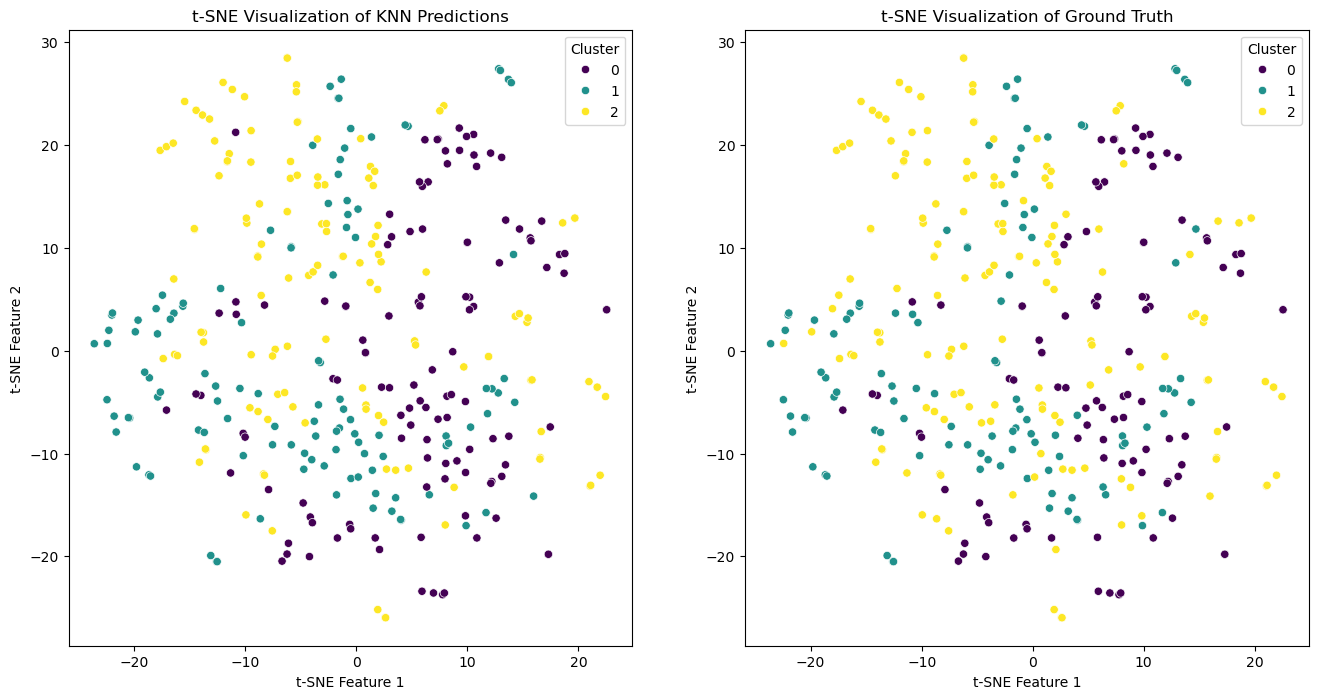

In [48]:
# Perform t-SNE dimensionality reduction for predicted values
tsne_pred = TSNE(n_components=2, random_state=42)
tsne_pred_features = tsne_pred.fit_transform(full)

# Perform t-SNE dimensionality reduction for ground truth values
tsne_true = TSNE(n_components=2, random_state=42)
tsne_true_features = tsne_true.fit_transform(full)

# Plot side by side
plt.figure(figsize=(16, 8))

# Plot for predicted values
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_pred_features[:, 0], y=tsne_pred_features[:, 1], hue=y_pred_raw, palette='viridis')
plt.title('t-SNE Visualization of KNN Predictions')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')

# Plot for ground truth values
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_true_features[:, 0], y=tsne_true_features[:, 1], hue=y, palette='viridis')
plt.title('t-SNE Visualization of Ground Truth')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')

plt.show()

## Fit a kNN classifier using PCA features: eigenfaces

Use PCA to extract features from the images and classify them using a KNN  algorithm. Keep as many PCA components as needed to explain 95% of the variance in the training set.

In [42]:
# GET PCA FEATURES PROJECTING TO THE PCA SPACE:
pca_full = pca95.fit_transform(full)

print('Number of PCA components needed to explain 95% of variability is {}'.format(Ncomponents_95))
print('The PCA full set has dimensions {} {}'.format(*pca_full.shape))

Number of PCA components needed to explain 95% of variability is 166
The PCA full set has dimensions 360 166


In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2) # load the model
knn.fit(pca_full, y) # fit the model using training data
y_pred = knn.predict(pca_full) # model prediction of test data

Text(0.5, 1.0, 'KNN pca features classification')

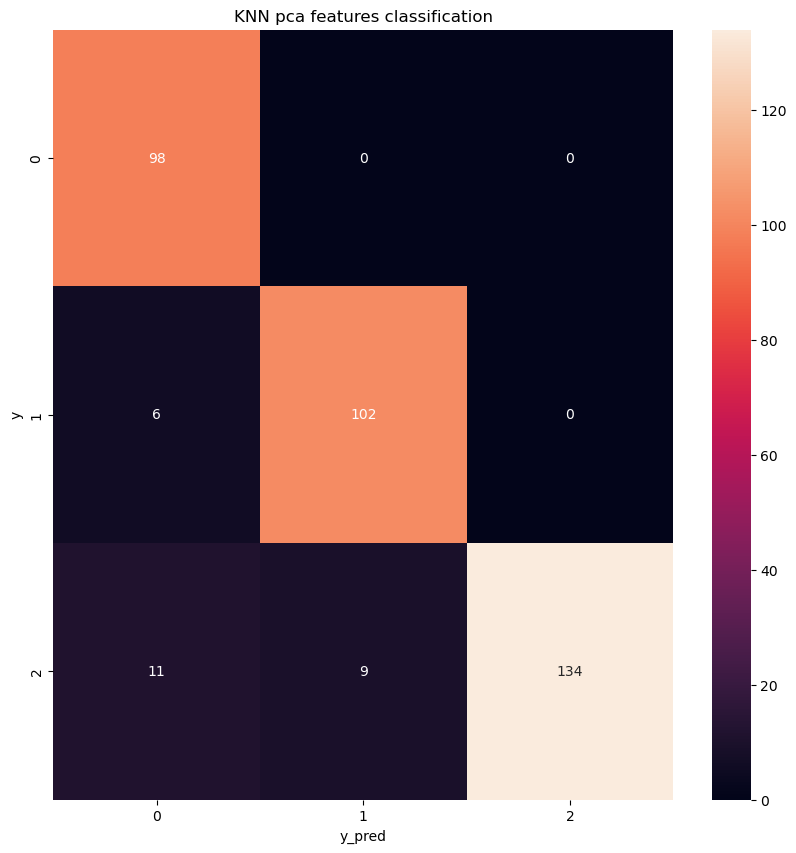

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, y_pred)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title('KNN pca features classification')

In [45]:
print(classification_report(y, y_pred, target_names=label_names))

              precision    recall  f1-score   support

        head       0.85      1.00      0.92        98
        neck       0.92      0.94      0.93       108
        body       1.00      0.87      0.93       154

    accuracy                           0.93       360
   macro avg       0.92      0.94      0.93       360
weighted avg       0.94      0.93      0.93       360



Traditional features do not always represent the full complexity of the classification problem

# Part 3: The DL approach

In [22]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 224, 224, 3)
(72, 224, 224, 3)
(288,)
(72,)


In [24]:
# Model / data parameters
num_classes = 3
input_shape = (224, 224, 3)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [25]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 186624)            0         
                                                                 
 dropout (Dropout)           (None, 186624)            0

In [26]:
import tensorflow as tf

In [27]:
batch_size = 8
epochs = 50
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks = [earlystop])

Epoch 1/50
33/33 [==============================] - 7s 39ms/step - loss: 1.1096 - accuracy: 0.4556 - val_loss: 0.9257 - val_accuracy: 0.5172
Epoch 2/50
33/33 [==============================] - 1s 20ms/step - loss: 0.7623 - accuracy: 0.6873 - val_loss: 0.7887 - val_accuracy: 0.6552
Epoch 3/50
33/33 [==============================] - 1s 20ms/step - loss: 0.3466 - accuracy: 0.9035 - val_loss: 0.5609 - val_accuracy: 0.8621
Epoch 4/50
33/33 [==============================] - 1s 20ms/step - loss: 0.0744 - accuracy: 0.9961 - val_loss: 0.6323 - val_accuracy: 0.7931
Epoch 5/50
33/33 [==============================] - 1s 20ms/step - loss: 0.0315 - accuracy: 0.9961 - val_loss: 0.5380 - val_accuracy: 0.8966
Epoch 6/50
33/33 [==============================] - 1s 20ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.5797 - val_accuracy: 0.8621
Epoch 7/50
33/33 [==============================] - 1s 20ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6339 - val_accuracy: 0.8621
Epoch 8/50
33

### Evaluate

In [35]:
score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers

Test loss: 0.9222628474235535
Test accuracy: 0.7083333134651184
3/3 [==============================] - 0s 17ms/step


In [36]:
model.save('2_fetal_clustering_TL_1.h5')

Create a new model from the trained one with the features as output

In [29]:
from tensorflow.keras.models import Model

base_model = model

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('features').output)
model_FE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 186624)            0     

### Visualize trained features using UMAP

In [30]:
df_test = model_FE.predict(x) # extract Deep trained features from text subset

12/12 [==============================] - 0s 14ms/step


In [32]:
x.shape

(360, 224, 224, 3)

In [ ]:
umap_df = umap.UMAP(n_neighbors=15).fit_transform(df_test.squeeze())

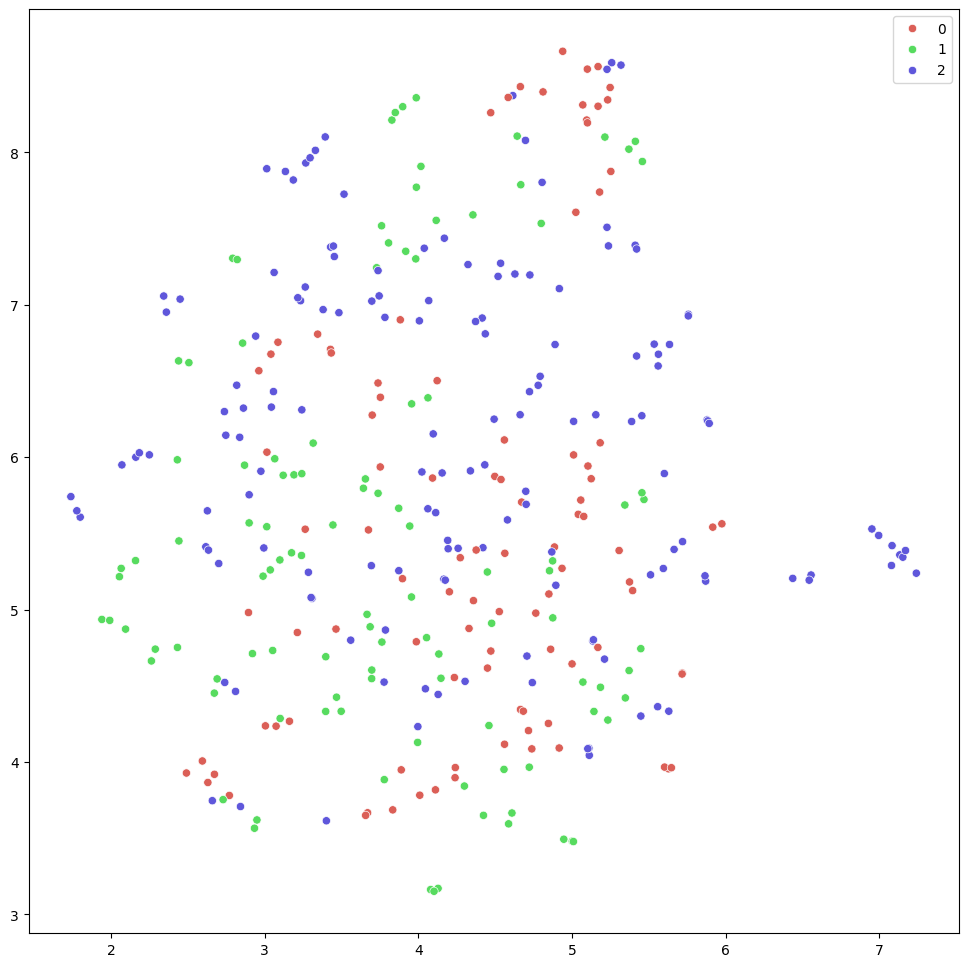

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

## Loading a higher accuracy model

In [ ]:
base_model = keras.models.load_model('/content/drive/MyDrive/Fetal_experiments/full_model_fetal_classifier (1).h5')

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)
model_FE.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
df_test = model_FE.predict(x) # extract Deep trained features from text subset

12/12 [==============================] - 86s 6s/step


In [ ]:
umap_df = umap.UMAP(n_neighbors=15).fit_transform(df_test.squeeze())

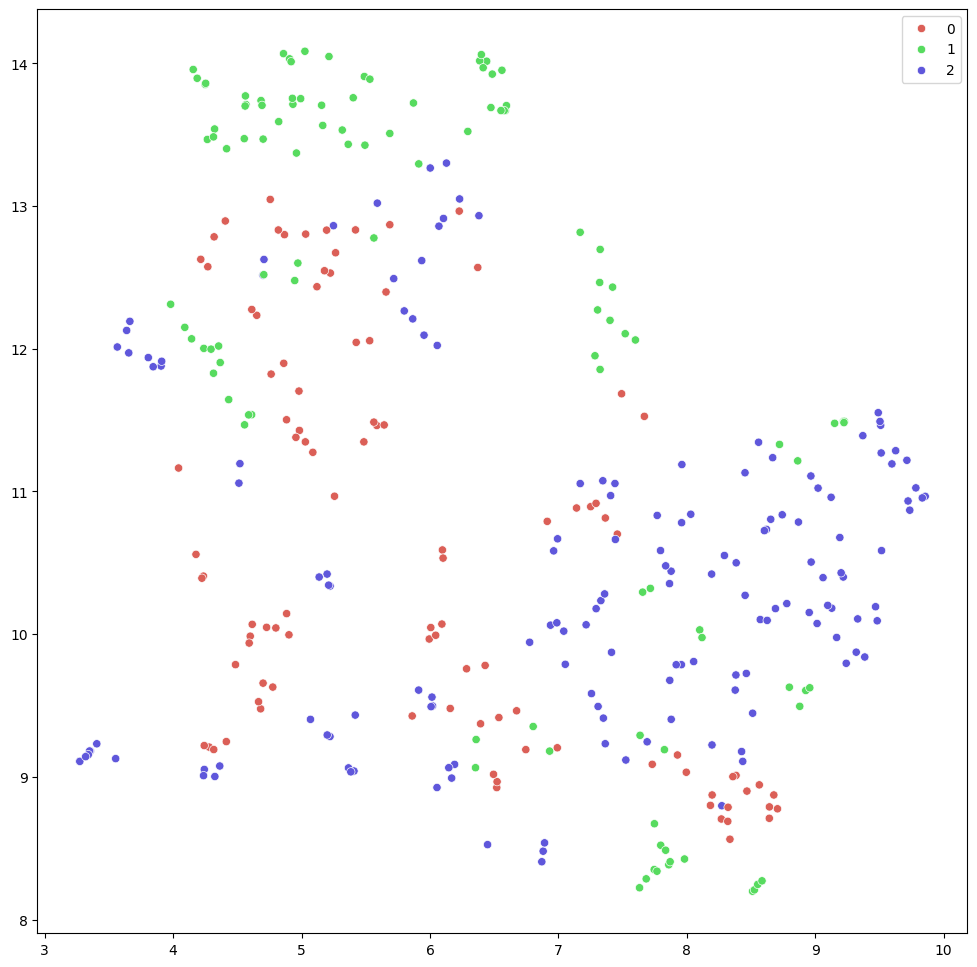

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

### Classify trained features using KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

# extract features from the training subset:
df_train = model_FE.predict(x)
knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
knn_DL.fit(df_train,y) # fit the model using training data
y_test_pred_DL = knn_DL.predict(df_test) # model prediction of test data

12/12 [==============================] - 77s 6s/step


              precision    recall  f1-score   support

        head       0.95      1.00      0.98        98
        neck       0.99      0.98      0.99       108
        body       1.00      0.97      0.99       154

    accuracy                           0.98       360
   macro avg       0.98      0.99      0.98       360
weighted avg       0.98      0.98      0.98       360



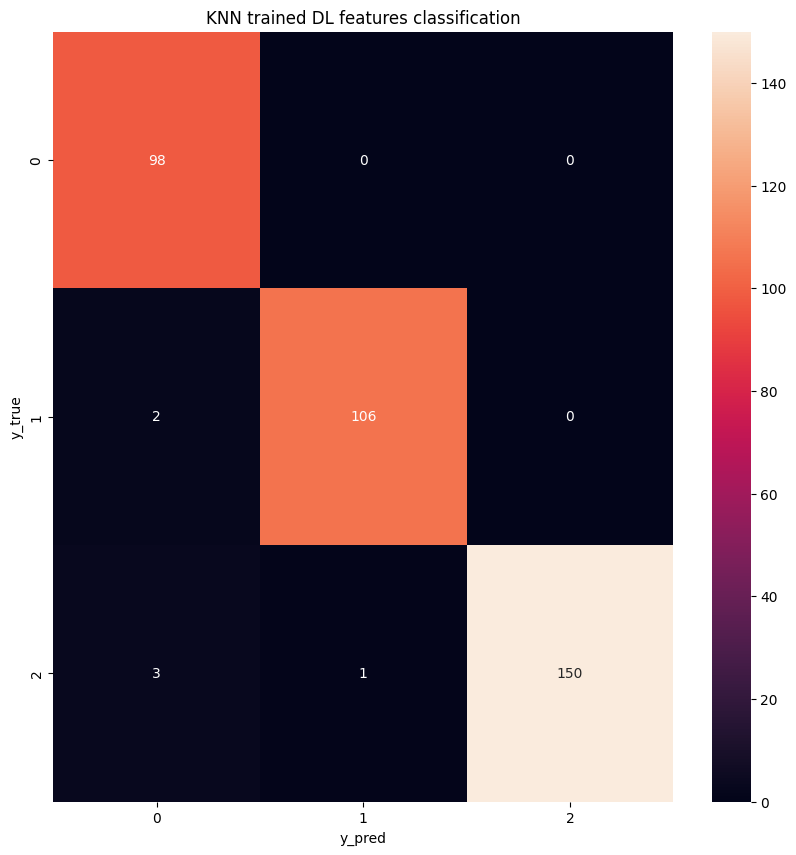

In [ ]:
cm_DL = confusion_matrix(y, y_test_pred_DL)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_DL,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN trained DL features classification')

print(classification_report(y, y_test_pred_DL, target_names=label_names))